In [1]:
# --> Test if variables are statistically dependent
# --> SVM Regression
# --> SIR
#TS Forcasting

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear
import sklearn.preprocessing as preproc
import statsmodels.api as sm
from scipy.optimize import curve_fit
import scipy.stats as st
from sklearn.metrics import r2_score
from scipy import signal

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_regression
from copy import deepcopy

from sklearn.preprocessing import normalize
sns.set()

In [3]:
oxgrt = pd.read_csv('./data/oxgrt/OxCGRT_latest.csv')
cols = oxgrt.columns
cols = [col for col in cols[6:] if 'Flag' not in col and 'Wildcard' not in col]
oxgrt2 = oxgrt.loc[oxgrt['CountryName'] == 'Austria']
#print(oxgrt2)
oxgrt2 = oxgrt2[cols].iloc[0:365]
oxgrt2.reset_index(inplace=True, drop=True)
#oxgrt2[oxgrt2.columns[:20]]


/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
print((2022-2020)*4-1)
print((2020-1970)*4-1)
print((1990-1970)*4-1)

7
199
79


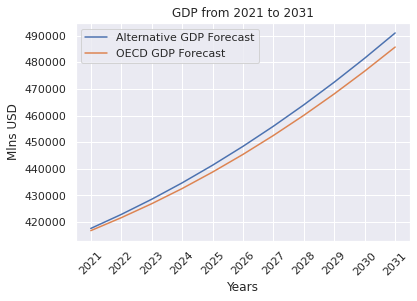

In [5]:
# Dec 2020
# https://data.oecd.org/gdp/real-gdp-long-term-forecast.htm#indicator-chart

# Nov 2019
# https://data.oecd.org/healthstat/life-expectancy-at-65.htm#indicator-chart

suicides = pd.read_csv('./data/oecd/oecd_suicides_90_2018.csv')
suicides = suicides.loc[suicides['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
alcohol = pd.read_csv('./data/oecd/oecd_alc_90_2018.csv')
alcohol = alcohol.loc[alcohol['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
yrslost = pd.read_csv('./data/oecd/oecd_pot_yrslost_90_2018.csv')
yrslost = yrslost.loc[yrslost['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
avg_wages = pd.read_csv('./data/oecd/oecd_avg_wages_90_2019.csv')
avg_wages = avg_wages.loc[avg_wages['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
gender_gap = pd.read_csv('./data/oecd/oecd_gender_gap_90_2018.csv')
gender_gap = gender_gap.loc[gender_gap['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
lifexp = pd.read_csv('./data/oecd/oecd_lif_exp_65_90_2019.csv')
lifexp = lifexp.loc[lifexp['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
infmort = pd.read_csv('./data/oecd/oecd_inf_mort_rate_90_2019.csv')
infmort = infmort.loc[infmort['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
cancdeath = pd.read_csv('./data/oecd/oecd_cancer_deaths_90_2018.csv')
cancdeath = cancdeath.loc[cancdeath['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
gdp = pd.read_csv('./data/oecd/oecd_real_gdp_fore_90_2060.csv')
gdp_past_18 = gdp.loc[gdp['LOCATION'] == 'AUT']['Value'][:len(suicides)].reset_index(drop=True)
gdp_past_20 = gdp.loc[gdp['LOCATION'] == 'AUT']['Value'][:len(suicides)+1].reset_index(drop=True)
gdp_forecast = gdp.loc[gdp['LOCATION'] == 'AUT']['Value'][len(suicides)+1:].reset_index(drop=True)

gdp_nom = pd.read_csv('./data/oecd/oecd_nom_gdp_fore_Q270_Q422.csv')
gdp_nom_20 = gdp_nom.loc[gdp_nom['LOCATION'] == 'AUT']['Value'][((1990-1970)*4)-1:
                                                                (2020-1970)*4-1].reset_index(drop=True)

gdp_nom_20_21 = gdp_nom.loc[gdp_nom['LOCATION'] == 'AUT']['Value'][(2020-1970)*4-1:
                                                                (2021-1970)*4-1].reset_index(drop=True)

gdp_nom_22 = gdp_nom.loc[gdp_nom['LOCATION'] == 'AUT']['Value'][((2021-1970)*4-1):].reset_index(drop=True)

'''
print(gdp_nom_20_21.head())
print(gdp_nom_20_21.tail())

print('-------------------------------------------')

print(gdp_nom_20.head())
print(gdp_nom_20.tail())

print('-------------------------------------------')

print(gdp_nom_22.head())
print(gdp_nom_22.tail())
'''

data_dict = {'suicides-p100kp-90-18' : np.array(suicides), 
             'alcohol-1lpp-90-18' : np.array(alcohol),
             'yrslost-p100kp-90-18' : np.array(yrslost),
             'avg_wages-usdpp-90-18' : np.array(avg_wages),
             'lifeexp65-yrspp-90-18' : np.array(lifexp),
             'infmort-p100kp-90-18' : np.array(infmort),
             'cancer_death-p100kp-90-18' : np.array(cancdeath),
             'gdp-usdmlns-90-18' : np.array(gdp_past_18),
             'gdp-usdmlns-90-20' : np.array(gdp_past_20),
             'gdp-usdmlns-20-60' : np.array(gdp_forecast),
             'gdp-nom-q190-q419' : np.array(gdp_nom_20),
             'gdp-nom-q120-q420' : np.array(gdp_nom_20_21),
             'gdp-nom-q190-q422' : np.array(gdp_nom_22)
            }

#plt.plot(data_dict['gdp-nom-q120-q420'])
#plt.show()

'''
poly1 = lambda x, a, b: a*(x**1) + b*(x**0)
poly2 = lambda x, a, b, c: a*(x**2) + b*(x**1) + c*(x**0)
poly3 = lambda x, a, b, c, d: a*(x**3) + b*(x**2) + c*(x**1) + d*(x**0)
poly4 = lambda x, a, b, c, d, e: a*(x**4) + b*(x**3) + c*(x**2) + d*(x**1) + e*(x**0)
poly5 = lambda x, a, b, c, d, e, f: a*(x**5) + b*(x**4) + c*(x**3) + d*(x**2) + e*(x**1) + f*(x**0)

def alt_fc(x, a, b, c, d, e, f):
    y = poly5(x, a, b, c, d, e, f)
    return np.abs(y*(y>0))


xdata = np.linspace(0,len(data_dict['gdp-usdmlns-90-20']),len(data_dict['gdp-usdmlns-90-20']))
popt_full_gpd, pcov_full_gpd = curve_fit(alt_fc, xdata, data_dict['gdp-usdmlns-90-20'], method='lm')

xdata = np.linspace(0,len(data_dict['gdp-usdmlns-20-60']),len(data_dict['gdp-usdmlns-20-60']))
alt_gdp_forcast = (alt_fc(xdata, *popt_full_gpd))#+
    #data_dict['gdp-usdmlns-90-20'][-1]-
    #alt_fc(xdata, *popt_full_gpd)[0])

data_dict['alt_gdp-usdmlns-20-60'] = alt_gdp_forcast
ticks=[0+i for i in range(0,10)]
labels=[2021+i for i in range(0,10)]
plt.plot(alt_gdp_forcast[:10], label='Alternative GDP Forecast')
plt.plot(gdp_forecast[:10], label='OECD GDP Forecast')
plt.xlabel("Years")
plt.ylabel("Mlns USD")
plt.yscale('log')
plt.xticks(ticks=ticks, 
           labels=labels)
plt.legend()
plt.show()

'''

nsig, kernlen = 3, 5
x = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(x))

alt_gdp_forcast = np.convolve(kern1d,
                np.concatenate((data_dict['gdp-usdmlns-90-20'][:-1], 
                                data_dict['gdp-usdmlns-20-60']), axis=0),
                'same')[29:]

all_gdp_forcast = np.concatenate((data_dict['gdp-usdmlns-90-20'], 
                                  data_dict['gdp-usdmlns-20-60']), axis=0)[29:-1]

alt_gdp_forcast = (alt_gdp_forcast - np.abs((all_gdp_forcast[0] - alt_gdp_forcast[0])))
timespan = 10
start = 2021
offset = start - 2019
ticks=[0+i for i in range(0,timespan+1)]
labels=[start+i for i in range(0,timespan+1)]
plt.plot(alt_gdp_forcast[offset:offset+timespan+1], label='Alternative GDP Forecast')
plt.plot(all_gdp_forcast[offset:offset+timespan+1], label='OECD GDP Forecast')
plt.xlabel("Years")
plt.ylabel("Mlns USD")
#plt.yscale('log')
plt.xticks(ticks=ticks, 
           labels=labels, rotation=45)
plt.legend()
plt.title("GDP from {} to {}".format(start, start+timespan))
plt.show()
data_dict['alt_gdp-usdmlns-20-60'] = alt_gdp_forcast[1:]

In [6]:
x = np.array(1.2345678).astype(np.float32)
x_hat = x.astype(np.float16)
print(x, x_hat)

x = np.array(1234567.8).astype(np.float32)
x = np.array(12345.8)
x_hat = x.astype(np.float16)
print(x, x_hat)

1.2345678 1.234
12345.8 12344.0


In [7]:

for key in data_dict:
    if 'gdp' not in key:
        print(key.upper())
        X, y = data_dict['gdp-usdmlns-90-18'], data_dict[key].reshape(-1,1)
        mod = sm.OLS(y, X)
        res = mod.fit()
        print(res.summary(),'\n\n')

#print(sum(res.predict(np.array([alt_gdp_forcast]).T)[:10]))
#print(sum(res.predict(np.array([gdp_forecast]).T)[:10]))




SUICIDES-P100KP-90-18
                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.876
Model:                            OLS   Adj. R-squared (uncentered):              0.872
Method:                 Least Squares   F-statistic:                              191.5
Date:                Tue, 15 Jun 2021   Prob (F-statistic):                    8.93e-14
Time:                        18:07:21   Log-Likelihood:                         -91.071
No. Observations:                  28   AIC:                                      184.1
Df Residuals:                      27   BIC:                                      185.5
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

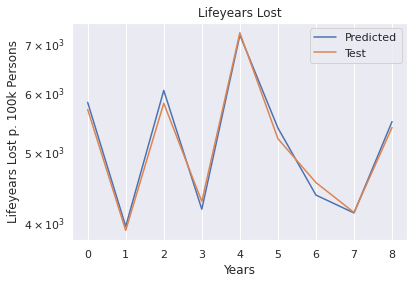

R2 Test 0.9820487509618121
RE Test 0.824681046670933
R2 Train 0.9897641984573147
RE Train 1.3149576332718134


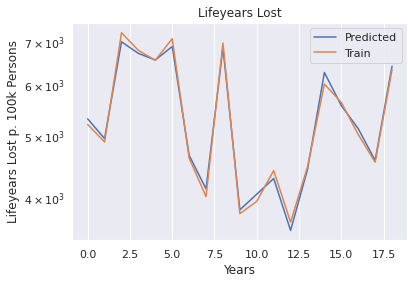

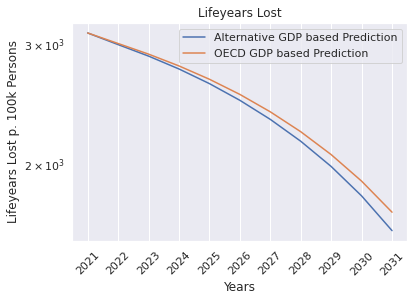

Lifeyears lost without econmic damage: 26723.314878315316
Lifeyears lost with historical econmoic damage: 27277.90885144744
Deaths occuring over the next 10 years will occur 0.5946851037199875 year(s) earlier


In [8]:
reg = make_pipeline(
    linear.Ridge(alpha=0.03, fit_intercept=True,
        normalize=True, copy_X=True, max_iter=100, tol=1e-6, solver='auto')
)

#Lifeyears Lost
X, y = data_dict['gdp-usdmlns-90-18'].reshape(-1,1), data_dict['yrslost-p100kp-90-18'].reshape(-1,1)
split = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg.fit(X_train, y_train.ravel())
ticks=[0+i for i in range(0,len(X_test))]
labels=[2021+i for i in range(0,len(X_test))]
y_pred = reg.predict(X_test)
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Test')
plt.xlabel('Years')
plt.ylabel('Lifeyears Lost p. 100k Persons')
plt.yscale('log')
#plt.xticks(ticks=ticks, 
#           labels=labels, rotation=45)
plt.legend()
plt.title('Lifeyears Lost')
plt.show()
print('R2 Test', reg.score(X_test, y_test), flush=True)
print('RE Test', np.linalg.norm(reg.predict(X_test)-y_test)/np.linalg.norm(y_test))
print('R2 Train', reg.score(X_train, y_train), flush=True)
print('RE Train', np.linalg.norm(reg.predict(X_train)-y_train)/np.linalg.norm(y_train))

ticks=[0+i for i in range(0,len(X_train))]
labels=[2021+i for i in range(0,len(X_train))]
y_pred = reg.predict(X_train)#.T[0]
plt.plot(y_pred, label='Predicted')
plt.plot(y_train, label='Train')
plt.xlabel('Years')
plt.ylabel('Lifeyears Lost p. 100k Persons')
plt.yscale('log')
#plt.xticks(ticks=ticks, 
#           labels=labels, rotation=45)
plt.legend()
plt.title('Lifeyears Lost')
plt.show()

duration = 11
ticks=[0+i for i in range(0,duration)]
labels=[2021+i for i in range(0,duration)]
plt.plot(reg.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1)), label='Alternative GDP based Prediction')
plt.plot(reg.predict(np.array(gdp_forecast[:duration]).reshape(-1,1)), label='OECD GDP based Prediction')
plt.xlabel('Years')
plt.ylabel('Lifeyears Lost p. 100k Persons')
plt.yscale('log')
plt.xticks(ticks=ticks, 
           labels=labels, rotation=45)
plt.legend()
plt.title('Lifeyears Lost')
plt.show()

no_ec = sum(reg.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1)))
ec = sum(reg.predict(np.array(gdp_forecast[:duration]).reshape(-1,1)))
avg_deaths_per_year = 8.3e5
print('Lifeyears lost without econmic damage:', no_ec) 
print('Lifeyears lost with historical econmoic damage:' ,ec)
print('Deaths occuring over the next 10 years will occur', ((ec-no_ec)*8.9e3)/10/avg_deaths_per_year, 'year(s) earlier')

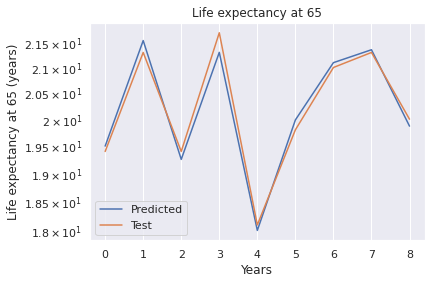

R2 Test 0.971503359244725
RE Test 0.23519407574614362
R2 Train -18271126.620160356
RE Train 0.38611742435639357


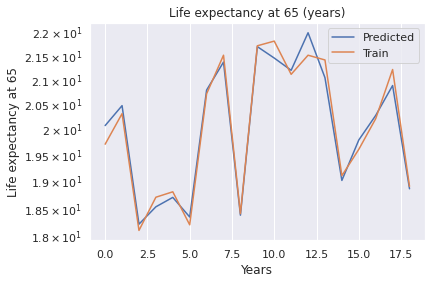

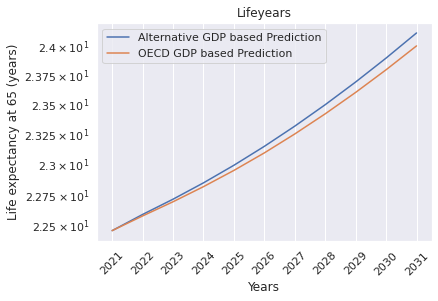

Average life expectancy at 65 over the next 10 years without econmic damage: 23.204250821783372
Average life expectancy at 65 over the next 10 years with historical econmoic damage: 23.149283036319193


In [9]:
reg_le = make_pipeline(
    linear.Ridge(alpha=0.003, fit_intercept=True,
        normalize=True, copy_X=True, max_iter=100, tol=1e-6, solver='auto')
)

#Lifeyears Lost
X, y = data_dict['gdp-usdmlns-90-18'].reshape(-1,1), data_dict['lifeexp65-yrspp-90-18'].reshape(-1,1)
split = 0.7
#X_train, y_train = X[:int(split*len(X))], y[:int(split*len(y))]
#X_test, y_test = X[int(split*len(X)):], y[int(split*len(y)):]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg_le.fit(X_train, y_train.ravel())
ticks=[0+i for i in range(0,len(X_test))]
labels=[2021+i for i in range(0,len(X_test))]
y_pred = reg_le.predict(X_test)
plt.plot(y_pred, label='Predicted')
plt.plot(y_test, label='Test')
plt.xlabel('Years')
plt.ylabel('Life expectancy at 65 (years)')
plt.yscale('log')
#plt.xticks(ticks=ticks, 
#           labels=labels, rotation=45)
plt.legend()
plt.title('Life expectancy at 65')
plt.show()
print('R2 Test', reg_le.score(X_test, y_test), flush=True)
print('RE Test', np.linalg.norm(reg_le.predict(X_test)-y_test)/np.linalg.norm(y_test))
print('R2 Train', reg.score(X_train, y_train), flush=True)
print('RE Train', np.linalg.norm(reg_le.predict(X_train)-y_train)/np.linalg.norm(y_train))

ticks=[0+i for i in range(0,len(X_train))]
labels=[2021+i for i in range(0,len(X_train))]
y_pred = reg_le.predict(X_train)#.T[0]
plt.plot(y_pred, label='Predicted')
plt.plot(y_train, label='Train')
plt.xlabel('Years')
plt.ylabel('Life expectancy at 65')
plt.yscale('log')
#plt.xticks(ticks=ticks, 
#           labels=labels, rotation=45)
plt.legend()
plt.title('Life expectancy at 65 (years)')
plt.show()

duration = 11
ticks=[0+i for i in range(0,duration)]
labels=[2021+i for i in range(0,duration)]
plt.plot(reg_le.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1)), label='Alternative GDP based Prediction')
plt.plot(reg_le.predict(np.array(gdp_forecast[:duration]).reshape(-1,1)), label='OECD GDP based Prediction')
plt.xlabel('Years')
plt.ylabel('Life expectancy at 65 (years)')
plt.yscale('log')
plt.xticks(ticks=ticks, 
           labels=labels, rotation=45)
plt.legend()
plt.title('Lifeyears')
plt.show()

no_ec = sum(reg_le.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1)))/duration
ec = sum(reg_le.predict(np.array(gdp_forecast[:duration]).reshape(-1,1)))/duration
avg_deaths_per_year = 8.3e5
print('Average life expectancy at 65 over the next 10 years without econmic damage:', no_ec) 
print('Average life expectancy at 65 over the next 10 years with historical econmoic damage:' ,ec)
#print('Deaths occuring over the next 10 years will occur', ((ec-no_ec)*8.9e3)/10/avg_deaths_per_year, 'year(s) earlier')

In [10]:
oxgrt = pd.read_csv('./data/oxgrt/OxCGRT_latest.csv')
cols = oxgrt.columns
cols = [col for col in cols[6:] if 'Flag' not in col and 'Wildcard' not in col]
oxgrt2 = oxgrt.loc[oxgrt['CountryName'] == 'Austria']
oxgrt2 = oxgrt2[cols].iloc[69:69+365]
oxgrt2.reset_index(inplace=True, drop=True)
oxgrt2 = oxgrt2.fillna(method="pad")
X_g = oxgrt2[oxgrt2.columns[:20]]
X_g.columns = [''.join(col.split('_')[1:]).replace(' ', '_').replace('/', '_') for col in X_g.columns]

y_ec = signal.resample(data_dict['gdp-nom-q120-q420'], 365)

irrelevant = [
#        'Debt_contract_relief',
#        'Fiscal_measures', 
#        'International_support', 
#        'Income_support', 
#        'Emergency_investment_in_healthcare',
#        'Investment_in_vaccines',
#        'Vaccination_policy'
]

X, y = X_g, y_ec
X.drop(irrelevant, axis=1, inplace=True)
pd.options.mode.chained_assignment = None 
repeat = True
while repeat:
    mod = sm.OLS(y, X)
    res = mod.fit()
    repeat = False
    idx_max, p_max = 0.0, 0.05
    for i in range(len(res.pvalues.index.tolist())):
        if res.pvalues[i] > p_max:
            p_max = res.pvalues[i]
            idx_max = i
            repeat = True
    if repeat:
        X.drop([res.pvalues.index.tolist()[idx_max]], axis=1, inplace=True)
print(X.columns)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary(),'\n\n')

Index(['School_closing', 'Workplace_closing', 'Cancel_public_events',
       'Close_public_transport', 'Stay_at_home_requirements',
       'Restrictions_on_internal_movement', 'International_travel_controls',
       'Public_information_campaigns', 'Contact_tracing', 'Facial_Coverings',
       'Vaccination_policy', 'Protection_of_elderly_people'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                     111.6
Date:                Tue, 15 Jun 2021   Prob (F-statistic):          5.12e-103
Time:                        18:07:23   Log-Likelihood:                -1486.0
No. Observations:                 365   AIC:                             2994.
Df Residuals:                     354   BIC:                             303

/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/media/lorenz/Volume/ubuntu/anaconda3/envs/p2/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
y_c = np.concatenate((data_dict['gdp-nom-q190-q419'], data_dict['gdp-nom-q120-q420']))
y_ec = signal.resample(y_c, 365*int(len(y_c)/4))
print(len(y_ec))

X_empty = X.copy(deep=True)
for col in X.columns:
    X_empty[col] = 0.0

X_new = pd.concat([X_empty]*int(len(y_c)/4-1)+[X]).reset_index(drop=True)
print(len(X_new))

11315
11315


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
res = MLPRegressor(random_state=1, max_iter=2500, 
                   hidden_layer_sizes = (365, 365),
                   activation='tanh', solver='adam',
                   learning_rate_init = 1e-3, shuffle=True,
                   tol=1e-6, early_stopping=True, validation_fraction=0.1
                  ).fit(X_train, y_train)
print(res.score(X_test, y_test))

0.8636248623189916


Nominal GDP Baseline Economic Impact: 1.0


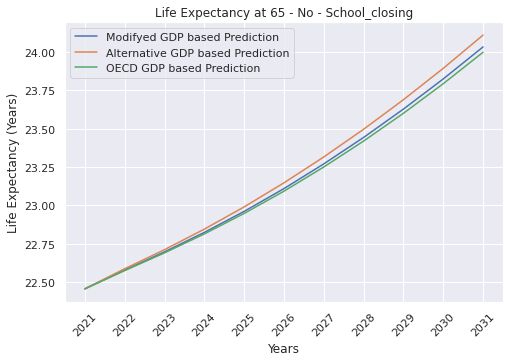

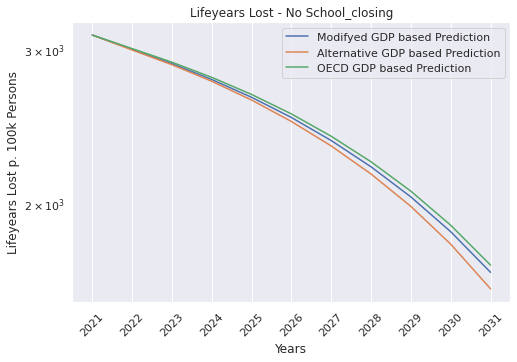

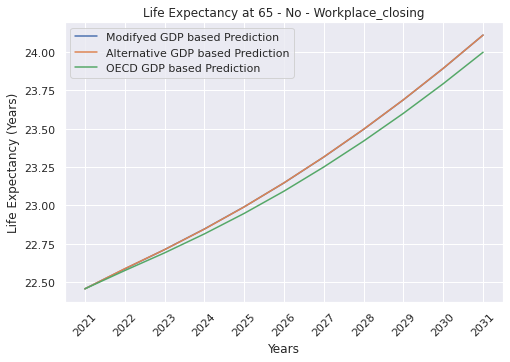

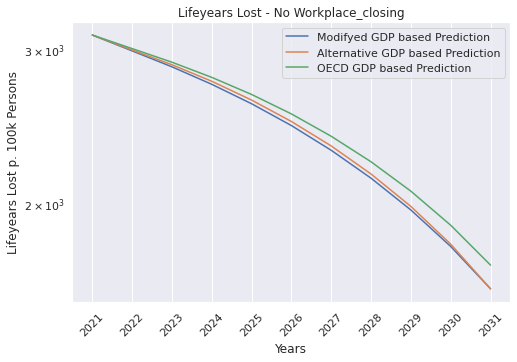

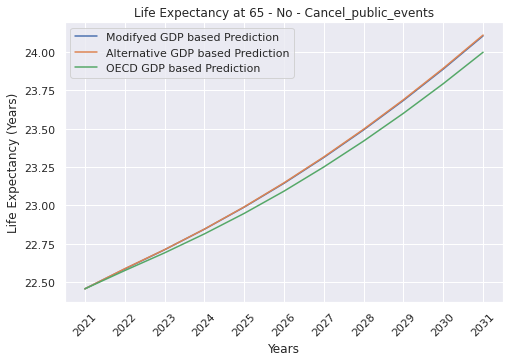

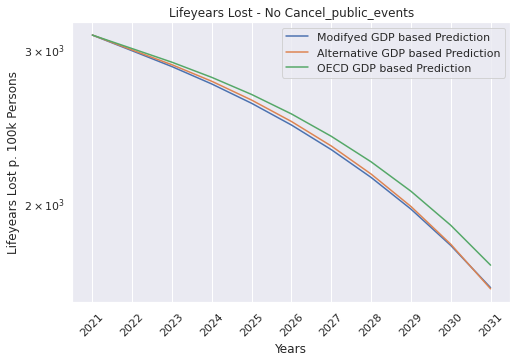

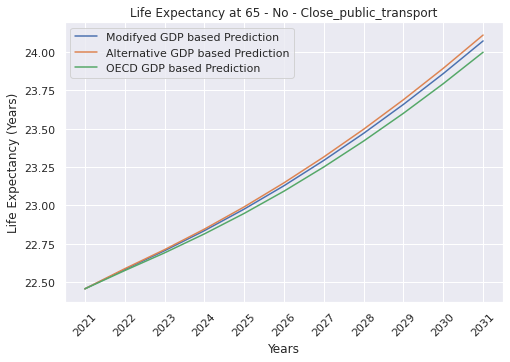

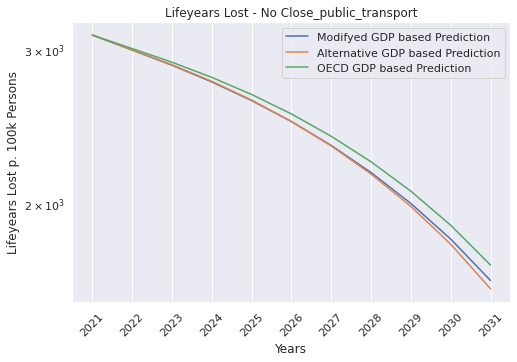

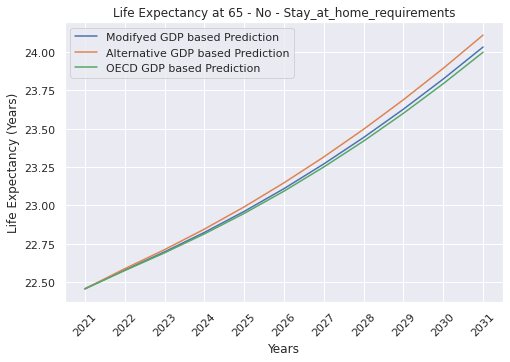

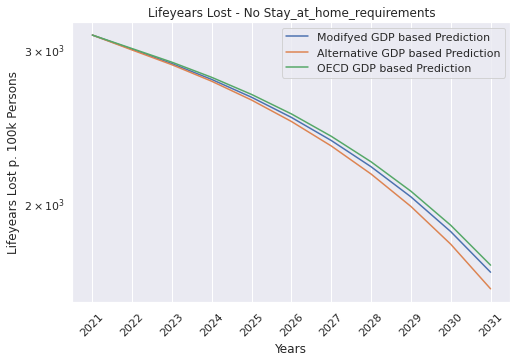

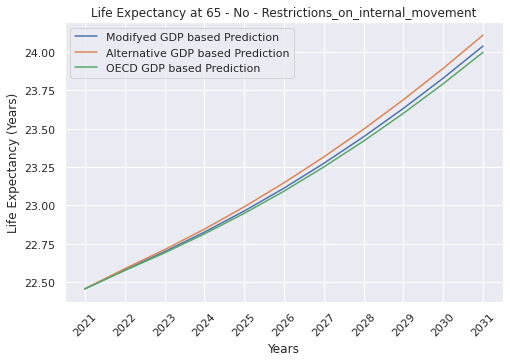

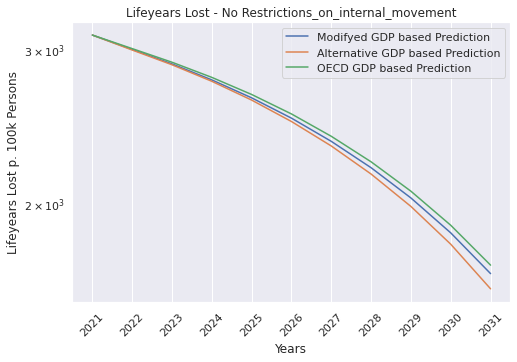

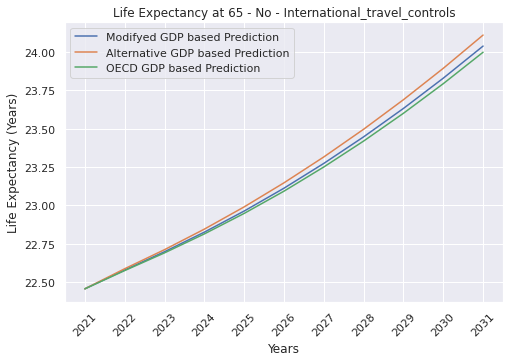

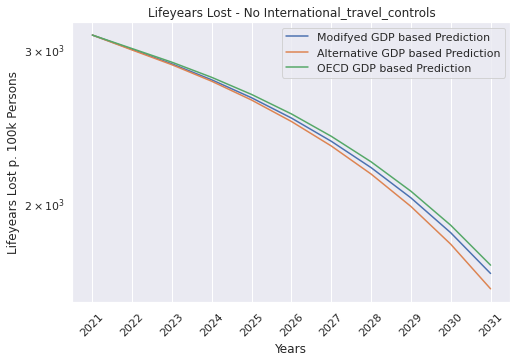

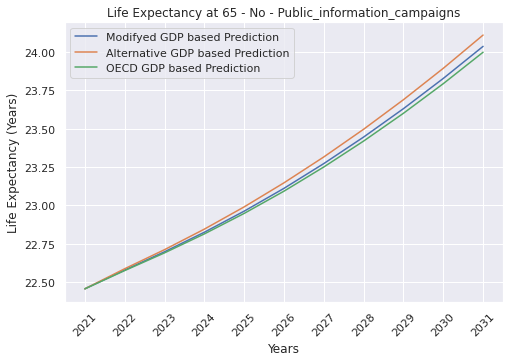

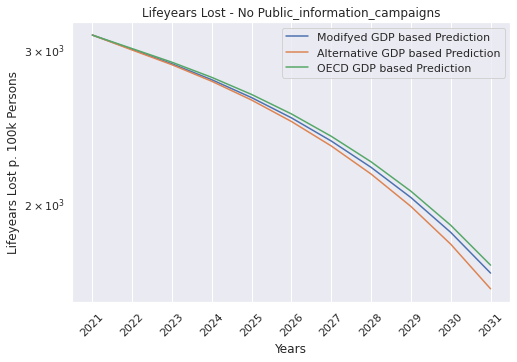

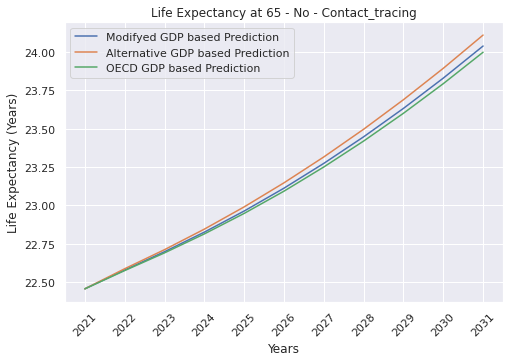

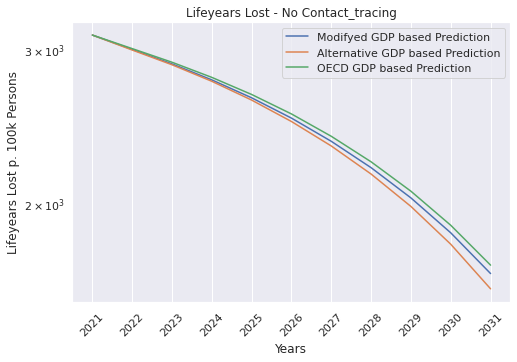

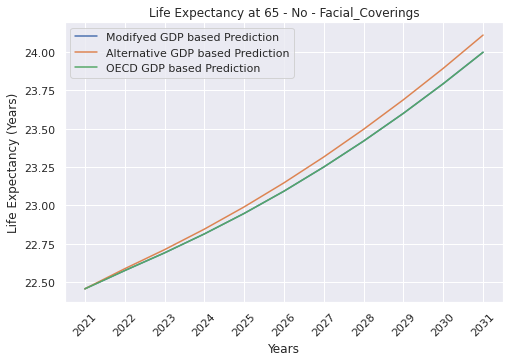

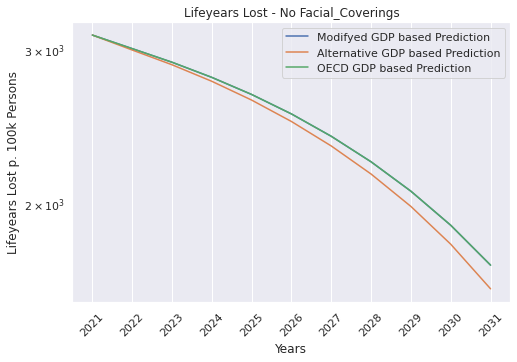

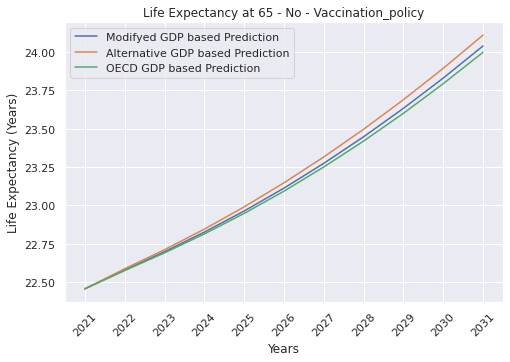

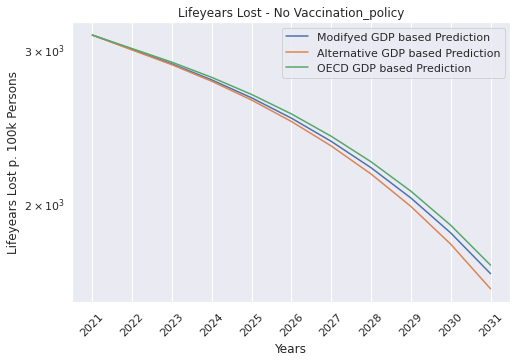

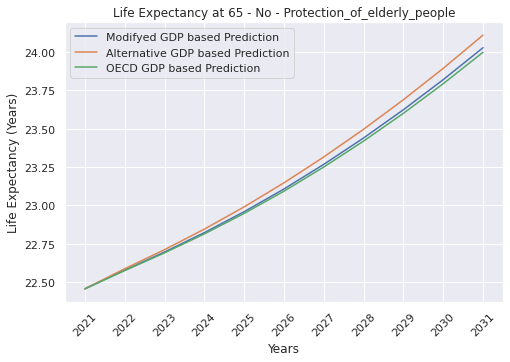

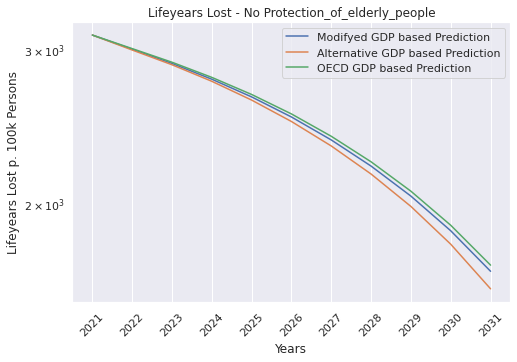

In [22]:
import datetime
sns.set(rc={'figure.figsize':(15.7*0.5,10.27*0.5)})
base = datetime.datetime(2020, 1, 1, 00, 00)
t = [base + datetime.timedelta(days=x) for x in range(365)]
    
bs = len(np.where(y > 0)[0])/len(y)
print('Nominal GDP Baseline Economic Impact:', len(np.where(y > 0)[0])/len(y)/bs)

#print(r2_score(y, np.convolve(res.predict(X), kern1d, 'same')))
r2 = r2_score(y, np.convolve(res.predict(X), kern1d, 'same'))

nsig, kernlen = 3, 110
x = np.linspace(-nsig, nsig, kernlen+1)
kern1d = np.diff(st.norm.cdf(x))

'''
pred = np.convolve(res.predict(X), kern1d, 'same')
metric = len(np.where(pred > 0)[0])/len(pred)/bs
print("Nominal GDP Regression Economic Impact {} +- {}".format(col, metric, metric*(1-r2)))
plt.plot(np.convolve(res.predict(X), kern1d, 'same'))
plt.plot(y)
plt.show()
'''

X_orig = X.copy(deep=True)
metrics = {}
for col in X_g.columns:
    X[col] = 0.0
    pred = np.convolve(res.predict(X), kern1d, 'same')
    metric = len(np.where(pred > 0)[0])/len(pred)/bs
    metrics[col] =  metric
    X = X_orig.copy(deep=True)
    
max_metric = max(metrics.values())
#print(max_metric)

alt_fc_le = reg_le.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1))
fc_le = reg_le.predict(np.array(gdp_forecast[:duration]).reshape(-1,1))
rate_le_upr = alt_fc_le/fc_le
rate_le_lwr = fc_le/fc_le

alt_fc_lo = reg.predict(np.array(alt_gdp_forcast[:duration]).reshape(-1,1))
fc_lo = reg.predict(np.array(gdp_forecast[:duration]).reshape(-1,1))
rate_lo_upr = alt_fc_lo/fc_lo
rate_lo_lwr = fc_lo/fc_lo

duration = 11
ticks=[0+i for i in range(0,duration)]
labels=[2021+i for i in range(0,duration)]
    
for col in X_g.columns:
    xp = [ticks[0], ticks[-1]]
    fp_le= [rate_le_lwr[0], 
          rate_le_lwr[-1]+(rate_le_upr[-1]-rate_le_lwr[-1])*(metrics[col]/max_metric)]
    
    fp_lo= [rate_lo_lwr[0], 
          rate_lo_lwr[-1]+(rate_lo_upr[-1]-rate_lo_lwr[-1])*(metrics[col]/max_metric)]
    
    plt.plot(fc_le*np.interp(ticks, xp, fp_le), label='Modifyed GDP based Prediction')
    plt.plot(alt_fc_le, label = 'Alternative GDP based Prediction')
    plt.plot(fc_le, label = 'OECD GDP based Prediction')
    plt.xlabel('Years')
    plt.ylabel('Life Expectancy (Years)')
    #plt.yscale('log')
    plt.xticks(ticks=ticks, 
               labels=labels, rotation=45)
    plt.legend()
    plt.title("Life Expectancy at 65 - No - {}".format(col))
    plt.show()
    
    plt.plot(fc_lo*np.interp(ticks, xp, fp_lo), label='Modifyed GDP based Prediction')
    plt.plot(alt_fc_lo, label = 'Alternative GDP based Prediction')
    plt.plot(fc_lo, label = 'OECD GDP based Prediction')
    plt.xlabel('Years')
    plt.ylabel('Lifeyears Lost p. 100k Persons')
    plt.yscale('log')
    plt.xticks(ticks=ticks, 
               labels=labels, rotation=45)
    plt.legend()
    plt.title("Lifeyears Lost - No {}".format(col))
    plt.show()
    

In [14]:
'''
duration = 11
ticks=[0+i for i in range(0,duration)]
labels=[2021+i for i in range(0,duration)]
plt.plot(alt_fc, label='Alternative GDP based Prediction')
plt.plot(fc*x, label='Intermediate')
plt.plot(fc, label='OECD GDP based Prediction')
plt.xlabel('Years')
plt.ylabel('Lifeyears Lost')
plt.yscale('log')
plt.xticks(ticks=ticks, 
           labels=labels, rotation=45)
plt.legend()
plt.title("Lifeyears Lost - No {}" .format(key))
plt.show()
''' 

'''
print(rate, flush=True)
for key in metrics:
    if metrics[key] < 1:
        metrics[key] = 1.0
    
    duration = 11
    ticks=[0+i for i in range(0,duration)]
    labels=[2021+i for i in range(0,duration)]
    plt.plot(alt_fc, label='Alternative GDP based Prediction')
    plt.plot(fc*1.001, label='OECD GDP based Prediction')
    plt.xlabel('Years')
    plt.ylabel('Lifeyears Lost')
    plt.yscale('log')
    plt.xticks(ticks=ticks, 
               labels=labels, rotation=45)
    plt.legend()
    plt.title("Lifeyears Lost - No {}" .format(key))
    plt.show()

X_orig = X.copy(deep=True)
for col in X_g.columns:
    X[col] = 0.0
    #plt.plot(t, np.convolve(res.predict(X), kern1d, 'same'), 
    #     label = "Nominal GDP No {}".format('Measures'))
#plt.legend()
#plt.show()
X = X_orig.copy(deep=True)
'''

'\nprint(rate, flush=True)\nfor key in metrics:\n    if metrics[key] < 1:\n        metrics[key] = 1.0\n    \n    duration = 11\n    ticks=[0+i for i in range(0,duration)]\n    labels=[2021+i for i in range(0,duration)]\n    plt.plot(alt_fc, label=\'Alternative GDP based Prediction\')\n    plt.plot(fc*1.001, label=\'OECD GDP based Prediction\')\n    plt.xlabel(\'Years\')\n    plt.ylabel(\'Lifeyears Lost\')\n    plt.yscale(\'log\')\n    plt.xticks(ticks=ticks, \n               labels=labels, rotation=45)\n    plt.legend()\n    plt.title("Lifeyears Lost - No {}" .format(key))\n    plt.show()\n\nX_orig = X.copy(deep=True)\nfor col in X_g.columns:\n    X[col] = 0.0\n    #plt.plot(t, np.convolve(res.predict(X), kern1d, \'same\'), \n    #     label = "Nominal GDP No {}".format(\'Measures\'))\n#plt.legend()\n#plt.show()\nX = X_orig.copy(deep=True)\n'

In [15]:
# Meeting June 1
# Lower bound
# Einschränkungen un Annahmen explizit im Report erwähnen. zB Wetterdaten.
# Dokumentation!
# Schwerpunkt Methodik: 
# Wie kann man Zusammenhänge modellieren, wie kann man überprüfen ob Zusammenhänge bestehen?
# Zwischen wichtigsten Ergenissen und denen trennen, die im Verlauf der Zeit angefallen sind. Apendix.
# Termin für Präsentation (20 min) Ende Juni (25.06 gegen Mittag, 29.06, 30.06. eventuell) 
# oder 2 Julihälfte, Fragen, Diskussion.
# Report vorbereitung für Paper (6-8 Seiten)
# Präsentation vor Bericht. Diskussion von Präsentation in Bereicht einarbeiten.